In [26]:
from src.data_utils import lire_alpha_digit
import numpy as np
from matplotlib import pyplot as plt

In [19]:

def init_RBM(num_visible: int, num_hidden: int, mu: float = 0, sigma: float = 0.01):
    """ 
    Initialize a Restricted Boltzmann Machine (RBM) with the given dimensions and parameters.
    
    :param num_visible: The dimension of the visible nodes (V).
    :param num_hidden: The dimension of the hidden nodes (H).
    :param mu: The mean of the normal distribution used to initialize the weights. Default is 0.
    :param sigma: The standard deviation of the normal distribution used to initialize the weights. Default is 0.01.
    
    :return: A dictionary representing the RBM with initialized weights and biases.
    """
    # Initialize the weights with random values from a normal distribution
    W = np.random.normal(mu, sigma, size=(num_visible, num_hidden))
    
    # Initialize the biases with zeros
    a = np.zeros(num_visible) # bias for visible nodes
    b = np.zeros(num_hidden)  # bias for hidden nodes
    
    # Create the RBM structure with initialized weights and biases
    rbm = {'W': W, 'a': a, 'b': b}
    
    return rbm

In [15]:
RBM = init_RBM(2,2)
print('W:', RBM['W'], '\na:', RBM['a'], '\nb:', RBM['b'])

W: [[-0.00471479 -0.00040472]
 [-0.01916697 -0.00446343]] 
a: [0. 0.] 
b: [0. 0.]


In [3]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

#### entree_sortie_rbm 

The core calculation performed by this function can be represented as follows:

$$P(h=1|v) = σ(a + W·v)$$

In [16]:
def entree_sortie_rbm(rbm, v):
        return sigmoid(rbm['b'] + np.dot(v, rbm['W']))

#### sortie_entree_rbm 

The core calculation performed by this function can be represented as follows:

$$P(v=1|h) = σ(b + W^T.h)$$

In [37]:
def sortie_entree_rbm(rbm, h):
        return sigmoid(rbm['a'] + np.dot(h, rbm['W'].T))


In [40]:
def train_RBM(X, rbm, epochs=100, learning_rate=0.1, batch_size=128):
    """
    param X: training data
    param rbm: the RBM model
    param epochs: number of training epochs
    param learning_rate: learning rate
    param batch_size: size of mini-batches
    :return the trained RBM model
    """
    for epoch in range(epochs):
        x = X.copy()
        np.random.shuffle(x)
        mse = 0

        for i in range(0, x.shape[0], batch_size):
            batch = x[i:i+batch_size]
            v0 = batch

            
            h0_prob = entree_sortie_rbm(rbm, v0)
            h0 = np.random.binomial(1, h0_prob)

            
            v1_prob = sortie_entree_rbm(rbm, h0)
            v1 = np.random.binomial(1, v1_prob)
            h1_prob = entree_sortie_rbm(rbm, v1)

            grad_W = np.dot(v0.T, h0) - np.dot(v1.T, h1_prob)
            grad_a = np.sum(v0 - v1, axis=0)
            grad_b = np.sum(h0 - h1_prob, axis=0)

            # Mise à jour des poids et biais
            rbm['W'] += learning_rate * grad_W / batch_size
            rbm['a'] += learning_rate * grad_a / batch_size
            rbm['b'] += learning_rate * grad_b / batch_size

            mse += np.mean((v0 - v1) ** 2)

        mse /= x.shape[0] // batch_size
        print(f"Epoch {epoch + 1}/{epochs}, Mean Square Error : {mse}")

    return rbm

In [45]:
def generer_image_RBM(rbm, nb_images,x_shape=28, y_shape=28, nb_iterations=100, Plot=False ):
    """
    param rbm: the trained RBM model
    param nb_iterations: number of iterations for Gibbs sampling
    param nb_images: number of images to generate
    """
    # Initialize the visible units randomly
    p = rbm['W'].shape[0]
    images = []
    for i in range(nb_images):
        v = np.random.binomial(1, 0.5 * np.ones(p))
        
        for _ in range(nb_iterations):
            
            h_prob = entree_sortie_rbm(rbm, v)
            h = np.random.binomial(1, h_prob)
            v_prob = sortie_entree_rbm(rbm, h)
            v = np.random.binomial(1, v_prob)
        images.append(v)
    if Plot:
        for i in range(nb_images):
            plt.subplot(1, nb_images, i+1)
            plt.imshow(images[i].reshape((x_shape, y_shape)), cmap='gray')  
            plt.axis('off')
        plt.show()

    return np.array(images)

## Test RBM Function

In [94]:
# Load the data
data_path = '../data/binary_alpha_digits/binaryalphadigs.mat'
X = lire_alpha_digit(data_path, np.arange(10))

In [95]:
n_b, p_b = X.shape
n_b, p_b

(390, 320)

In [84]:
q = 1000
RBM = init_RBM(p_b, q)

In [85]:
RBM = train_RBM(X, RBM, epochs=100, learning_rate=0.1, batch_size=128)

Epoch 1/100, Mean Square Error : 0.6101860894097223
Epoch 2/100, Mean Square Error : 0.5702067057291668
Epoch 3/100, Mean Square Error : 0.555007595486111
Epoch 4/100, Mean Square Error : 0.5626953124999999
Epoch 5/100, Mean Square Error : 0.5760498046875
Epoch 6/100, Mean Square Error : 0.5595296223958333
Epoch 7/100, Mean Square Error : 0.5590901692708333
Epoch 8/100, Mean Square Error : 0.5396077473958334
Epoch 9/100, Mean Square Error : 0.5551974826388889
Epoch 10/100, Mean Square Error : 0.5393364800347222
Epoch 11/100, Mean Square Error : 0.5472086588541667
Epoch 12/100, Mean Square Error : 0.5063422309027777
Epoch 13/100, Mean Square Error : 0.5075032552083333
Epoch 14/100, Mean Square Error : 0.4960313585069444
Epoch 15/100, Mean Square Error : 0.49092068142361106
Epoch 16/100, Mean Square Error : 0.4925726996527778
Epoch 17/100, Mean Square Error : 0.4865695529513889
Epoch 18/100, Mean Square Error : 0.47829318576388885
Epoch 19/100, Mean Square Error : 0.4576904296875
Epoch 2

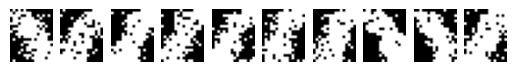

In [86]:
generated_images = generer_image_RBM(RBM, 10, x_shape=20, y_shape=16, nb_iterations=100, Plot=True)

## RBM Class

In [87]:
class RBM:
    def __init__(self, num_visible: int, num_hidden: int, mu: float = 0, sigma: float = 0.01):
        """ 
        Initialize a Restricted Boltzmann Machine (RBM) with the given dimensions and parameters.
        
        :param num_visible: The dimension of the visible nodes (V).
        :param num_hidden: The dimension of the hidden nodes (H).
        :param mu: The mean of the normal distribution used to initialize the weights. Default is 0.
        :param sigma: The standard deviation of the normal distribution used to initialize the weights. Default is 0.01.
        
        :return: A dictionary representing the RBM with initialized weights and biases.
        """
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.W = np.random.randn(num_hidden, num_visible)
        self.a = np.random.randn(num_visible)
        self.b = np.random.randn(num_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def entree_sortie(self, v):
        """
        Compute the probability P(h=1|v) of the hidden nodes given the visible nodes.
        """
        return self.sigmoid(self.b + np.dot(v, self.W))
    
    def sortie_entree(self, h):
       
        """
        Compute the probability P(v=1|h) of the visible nodes given the hidden nodes.
        """
        return self.sigmoid(self.a + np.dot(h, self.W.T))

    def train(self, X, epochs=100, learning_rate=0.1, batch_size=128):
        """
        param X: training data
        param rbm: the RBM model
        param epochs: number of training epochs
        param learning_rate: learning rate
        param batch_size: size of mini-batches
        :return the trained RBM model
        """
        for epoch in range(epochs):
            x = X.copy()
            np.random.shuffle(x)
            mse = 0

            for i in range(0, x.shape[0], batch_size):
                batch = x[i:i+batch_size]
                v0 = batch

                h0_prob = self.entree_sortie(v0)
                h0 = np.random.binomial(1, h0_prob)

                v1_prob = self.sortie_entree(h0)
                v1 = np.random.binomial(1, v1_prob)
                h1_prob = self.entree_sortie(v1)

                grad_W = np.dot(v0.T, h0) - np.dot(v1.T, h1_prob)
                grad_a = np.sum(v0 - v1, axis=0)
                grad_b = np.sum(h0 - h1_prob, axis=0)

                self.W += learning_rate * grad_W / batch_size
                self.a += learning_rate * grad_a / batch_size
                self.b += learning_rate * grad_b / batch_size

                mse += np.mean((v0 - v1) ** 2)

            mse /= x.shape[0] // batch_size
            print(f"Epoch {epoch + 1}/{epochs}, Mean Square Error : {mse}")
            
    def generate_images(self, nb_images, x_shape=28, y_shape=28, nb_iterations=100, Plot=False):
        """
        param rbm: the trained RBM model
        param nb_iterations: number of iterations for Gibbs sampling
        param nb_images: number of images to generate
        """
        images = []
        for _ in range(nb_images):
            v = np.random.binomial(1, 0.5 * np.ones(self.num_visible))
            
            for _ in range(nb_iterations):
                h_prob = self.entree_sortie(v)
                h = np.random.binomial(1, h_prob)
                v_prob = self.sortie_entree(h)
                v = np.random.binomial(1, v_prob)
            
            images.append(v)
        
        if Plot:
            for i in range(nb_images):
                plt.subplot(1, nb_images, i+1)
                plt.imshow(images[i].reshape((x_shape, y_shape)), cmap='gray')  
                plt.axis('off')
            plt.show()

        return np.array(images)

from data_utils.principal_RBM_alpha import RBM

In [90]:
from src.rbm.principal_RBM_alpha import RBM

In [97]:
q=1000
rbm = RBM(n_b,q)
rbm.train(X, epochs=100, learning_rate=0.1, batch_size=128)
rbm.generate_images(10, x_shape=20, y_shape=16, nb_iterations=100, Plot=True)

ValueError: shapes (128,320) and (1000,390) not aligned: 320 (dim 1) != 1000 (dim 0)